## PhD Computational Methods Assignment 1 

#### The model: 
A household consumes and supplies labour in the following way:
$$R(a,z) = \max \{ W(a,z), N(a,z) \}$$
where 
$$W(a,z) = \max\limits_{c,n,a'} \; log(c) - \eta \frac{n^{1 + \frac{1}{\chi}}}{1 + \frac{1}{\chi}} + \beta\log(a')$$
$$ \textbf{s.t.} \quad c + a' = zn(1-\tau)w + (1 + (1-\tau)r)a + T, \; c\geq 0,\; a'\geq 0,\; n \in (0,1]$$

$$N(a,z) = \max\limits_{c,a'} \; log(c) + \beta\log(a')$$
$$ \textbf{s.t.} \quad c + a' = b + (1 + (1-\tau)r)a + T, \; c\geq 0,\; a'\geq 0$$

This is a simple static model, assume assets $a=1=K$ for all agents, $z$ satisfies $\log(z) \sim IID N(0,\sigma_z)$, $b$ is unemployment benefits, $\tau$ is fixed tax rate, and $T$ is lump-sum transfers. The production sector operates as follows: 
$$ Y = \max\limits_{L} \; A K^\alpha L^{1-\alpha} - wL - (r+\delta)K$$

The government budget balance condition is as follows:
$$ \int_\Phi (wzh + ar) \tau d\Phi = \int_{\Phi} b\mathbb{1}(NW) d\Phi + T$$

where $h = n \mathbb{1}(W)$ such that $\mathbb{1}()$ is an indicator function that takes the value 1 if an individual is working (intensive margin), and $\mathbb{1}(NW)$ is an indicator function that takes the value 1 if the individual is not working (unemployed). All marketsw clear (take capital to exogeneously clear) and wage is determined from the labour clearing condition:
$$ L^* = \int_\Phi zn(z) d\Phi$$
where 
$$L^* = K \left( \frac{A(1-\alpha)}{w} \right)^\frac{1}{\alpha}$$

The worker's optimality conditions become:
\begin{align}
a'(z) &= \beta c(z) \\
n(z)&= \left( \frac{(1-\tau)zw}{\eta c(z)} \right)^\chi
\end{align}
which combined with the budget constraint yields the following implicit equation for worker's optimal consumption:
$$
\begin{equation} (1+\beta)c(z) = ((1-\tau)zw)^{1+\chi}(\eta c(z))^{-\chi} + (1 + (1-\tau)r)a + T \end{equation}
$$

The optimality conditions for the non-worker individual are as follows: 
\begin{align} 
a'^* &= \beta c^* \\
c^* &= \frac{b + (1 + (1-\tau)r)a + T}{1+\beta}
\end{align}

#### Solving The Workers Optimisation Problem

In [24]:
# import useful packages 
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt

# declare parameters 
pa = 1 # individual asset position (wealth) is fixed and normalized to 1
palpha = 0.3 # alpha parameter (Cobb-Douglas)
ptau = 0.15 # tax rate 
pA = 1 # TFP (normalized)
pbeta = 0.96 # beta (discount factor)
pchi = 1 # Frisch elasticity parameter chi
peta = 0.7 # disutility of labour parameter eta 
pstdz = 1 # standard deviation of z 
pmeanz = 0 # mean of z 
pdelta = 0.04 # depreciation rate  
pb = 0.36 # unemployment benefits

# setting prices 
pr = 0.04 # interest rate (assumed to be exogeneously determined)
w_temp = 2 # initial guess for wage rate 

# setting transfers 
T_temp = 2 # initial guess for government transfers

In [25]:
# consumption solver for the worker 
def ConsumptionSolverIfWorker(beta, tau, chi, eta, alpha, z, w, r, T, c0):
    c = c0
    err = 1
    i = 0
    converge = False
    while err > 1e-4: #and i <= 10000: # number of max iterations is very large as this iteration solver is very fast (for stable systems) 
        RHS = ((1-tau)*z*w)**(1+chi) * (eta*c)**(-chi) + (1 + (1-tau)*r)*alpha + T
        c_new = RHS / (1 + beta)
        err = abs(c_new - c)
        c = c_new
        i += 1

    a = beta * c
    if err <= 1e-4:
        #print(f"Consumption solver for worker converged after {i} iterations.")
        return c, a # Return the final consumption level if converged
    else:
        return "Consumption solver for worker failed to converge after 10000 iterations"  # Return failure message if max iterations reached    

# consumption for non-worker 
def ConsumptionNotWorker(beta, tau, alpha, r, T, b):
    c = (b + (1 + (1-tau)*r)*alpha + T)/(1 + beta)
    a = beta * c
    return c, a

In [26]:
# intensive labour supply for worker 
def IntensiveLabourSupply(tau, chi, eta, z, w, c):
    n = (((1-tau)*z*w)/(eta*c))**chi
    return n

In [27]:
# value functions for each individual type (worker and non-worker)
# worker
def W(c, n, aprime, beta, eta, chi):
    W = np.log(c) - beta*(n**(1+1/chi))/(1+1/chi) + beta*np.log(aprime)
    return W 

# non-worker
def N(c, aprime, beta):
    N = np.log(c) + beta*np.log(aprime)
    return N

### Plot Individual Labour Supply Curve

In [28]:
# individual Labour Supply Curve for different productivity levels given wage (w)
def LabourSupplyCurve(beta, tau, chi, eta, alpha, b, z_grid, Nz, w, r, T, c0):
    labour_supply = np.zeros(Nz) # create a placeholder for labour_supply levels
    n_notworker = 0
    
    for i, z in enumerate(z_grid):
        # solve consumption-saving problem for worker
        result = ConsumptionSolverIfWorker(beta, tau, chi, eta, alpha, z, w, r, T, c0)
        
        # Check if the solver returned an error message
        if isinstance(result, str):
            raise ValueError(result)  # Raise an error with the solver's failure message

        c_ifworker, aprime_ifworker = ConsumptionSolverIfWorker(beta, tau, chi, eta, alpha, z, w, r, T, c0)
        n_ifworker = IntensiveLabourSupply(tau, chi, eta, z, w, c_ifworker)

        # solve consumption-saving problem for non-worker
        c_notworker, aprime_notworker = ConsumptionNotWorker(beta, tau, alpha, r, T, b)

        # compute value functions for each individual type (worker and non-worker)
        W_val = W(c_ifworker, n_ifworker, aprime_ifworker, beta, eta, chi)
        N_val = N(c_notworker, aprime_notworker, beta)

        # Labour supply decision based on value comparison
        if W_val > N_val:
            labour_supply[i] = n_ifworker  # Intensive margin if worker
        else:
            labour_supply[i] = n_notworker  # Extensive margin if non-worker

    return labour_supply

# create a grid for productivity draws
Nz = 100
z_grid = np.linspace(0, 4, num=100)

# calculate individual labor supply curve (labour supply over the z-grid)
labour_supply_curve = LabourSupplyCurve(beta=pbeta, tau=ptau, chi=pchi, eta=peta, alpha=palpha, b=pb, z_grid=z_grid, Nz=Nz, 
                                        w=w_temp, r=pr, T=T_temp, c0=1)

In [29]:
# individual Labour Supply Curve for different wage levels given productivity (z)
def LabourSupplyCurveAlternative(beta, tau, chi, eta, alpha, b, w_grid, z, r, T, c0):
    labour_supply = np.zeros(len(w_grid)) # create a placeholder for labour_supply levels
    n_notworker = 0
    
    for i, w in enumerate(w_grid):
        # solve consumption-saving problem for worker
        result = ConsumptionSolverIfWorker(beta, tau, chi, eta, alpha, z, w, r, T, c0)
        
        # Check if the solver returned an error message
        if isinstance(result, str):
            raise ValueError(result)  # Raise an error with the solver's failure message

        c_ifworker, aprime_ifworker = result
        n_ifworker = IntensiveLabourSupply(tau, chi, eta, z, w, c_ifworker)

        # solve consumption-saving problem for non-worker
        c_notworker, aprime_notworker = ConsumptionNotWorker(beta, tau, alpha, r, T, b)

        # compute value functions for each individual type (worker and non-worker)
        W_val = W(c_ifworker, n_ifworker, aprime_ifworker, beta, eta, chi)
        N_val = N(c_notworker, aprime_notworker, beta)

        # Labour supply decision based on value comparison
        if W_val > N_val:
            labour_supply[i] = n_ifworker  # Intensive margin if worker
        else:
            labour_supply[i] = n_notworker  # Extensive margin if non-worker

    return labour_supply

# characterize alternative labour supply curve 
w_grid = np.linspace(0.01,5,100)
labour_supply_curve_alternative = LabourSupplyCurveAlternative(beta=pbeta, tau=ptau, chi=pchi, eta=peta, alpha=palpha, b=pb, 
                                                               w_grid=w_grid, z=1, r=pr, T=T_temp, c0=1)

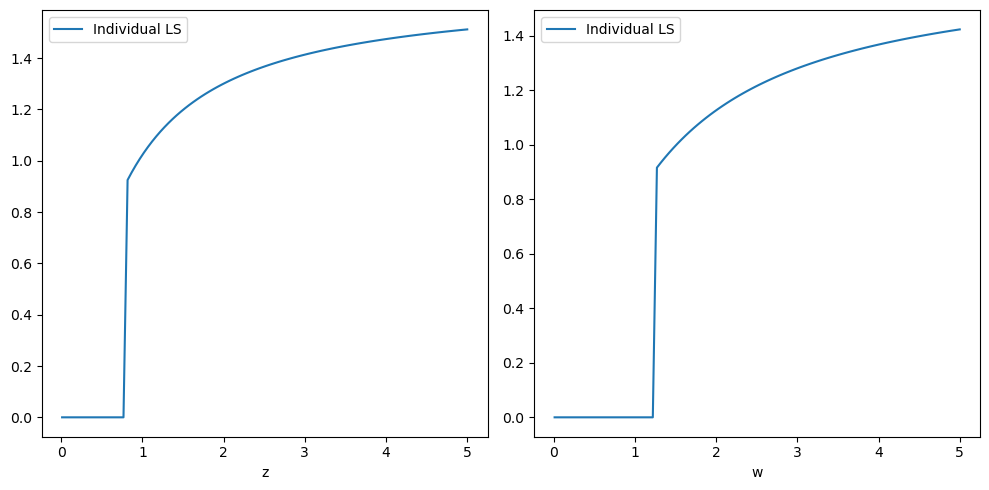

In [30]:
# Plot the individual labor supply curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# LS over z plot
ax1.plot(w_grid, labour_supply_curve, label='Individual LS')
ax1.set_xlabel('z')
ax1.legend()

# LS over w plot 
ax2.plot(w_grid, labour_supply_curve_alternative, label='Individual LS')
ax2.set_xlabel('w')
ax2.legend()

plt.tight_layout()
plt.show()

### Plot Aggregate Labour Supply and Aggregate Labour Demand Curves

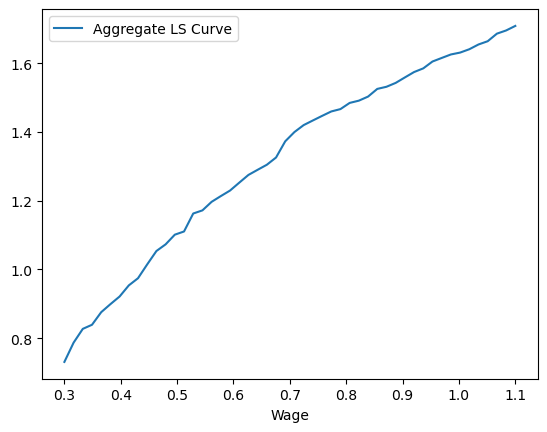

In [31]:
# aggregate labour supply curve 
def AggLabourSupplyCurve(beta, tau, chi, eta, alpha, b, Nz, zmean, zstd, w_grid, r, T, c0):
    z_draws = np.exp(np.random.normal(zmean, zstd, Nz))
    agg_labour_supply = np.zeros(Nw)

    # compute aggregate labour supply over the population (z-draws) for each wage level
    for i, w in enumerate(w_grid):
        # vector of labour supply for given wage over Nz productivity (z) draws
        vLabourSupply = LabourSupplyCurve(beta=beta, tau=tau, chi=chi, eta=eta, alpha=alpha, b=b, z_grid=z_draws, Nz=Nz, w=w, r=r, T=T, c0=c0)

        # compute aggregate labour supply (Monte Carlo Integration)
        agg_labour_supply[i] = np.mean(z_draws*vLabourSupply)

    return agg_labour_supply

# create grid for productivity draws and wage
Nzdraws = 250
w_min, w_max, Nw = 0.3, 1.1, 50
w_grid = np.linspace(w_min, w_max, Nw)

# compute aggregate labour supply over productivity and wage grids (simulated economy)
agg_labour_supply_curve = AggLabourSupplyCurve(beta=pbeta, tau=ptau, chi=pchi, eta=peta, alpha=palpha, b=pb, Nz=Nzdraws, 
                                               zmean=pmeanz, zstd=pstdz, w_grid=w_grid, r=pr, T=T_temp, c0=1) 

# plot aggregate LS and LD curves
plt.plot(w_grid, agg_labour_supply_curve, label='Aggregate LS Curve')
plt.xlabel('Wage')
plt.legend()
plt.show()

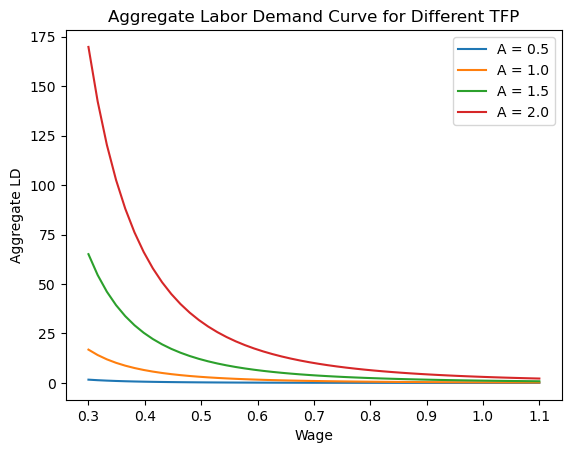

In [32]:
# aggregate labour demand curve for different As 
A = np.array([0.5, 1, 1.5, 2])
agg_labour_demand_curve = np.zeros((len(A), len(w_grid)))  # Initialize a 2D array

for i, j in enumerate(A):
    agg_labour_demand_curve[i] = (j * (1 - palpha) / w_grid) ** (1 / palpha)

# plot AD for different values of A over wages
for i, j in enumerate(A):
    plt.plot(w_grid, agg_labour_demand_curve[i], label=f'A = {j}')

plt.xlabel('Wage')
plt.ylabel('Aggregate LD')
plt.title('Aggregate Labor Demand Curve for Different TFP')
plt.legend()
plt.show()

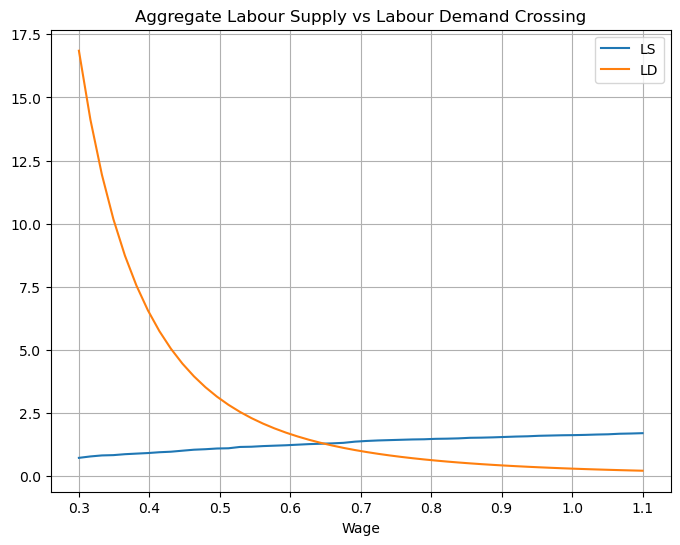

In [33]:
# AD and AS Crossing 
plt.figure(figsize=(8,6))

plt.plot(w_grid, agg_labour_supply_curve, label='LS')
plt.plot(w_grid, agg_labour_demand_curve[1], label='LD')
plt.title('Aggregate Labour Supply vs Labour Demand Crossing')
plt.xlabel('Wage')
plt.grid(True)
plt.legend()
plt.show()

### Solving for GE

#### Calibration of the Model: 
The moments we are interested are as follows:
$$ \begin{equation} M_1 := \int_{z<z^*(a)} d\Phi \end{equation} $$
$$ \begin{equation} M_2 := \frac{\int_{z<z^*(a)} b d\Phi}{\int_\Phi wzh(a,z) d\Phi} = \frac{b M_1}{\int_\Phi wzh(a,z) d\Phi} \end{equation} $$ 
$$ \begin{equation} M_3 := \frac{\text{std}(wzh(a,z))}{\text{mean}(wzh(a,z))} \end{equation} $$

with the following targets: 
$$ M_1^* = 0.06,\; M_2^* = 0.25, \; M_3^* = 0.7 $$

The approach to acheive targeted moments is to minimise the following (quadratic) loss function: 
$$ \min\limits_{\theta = (\eta, b, \sigma_z)'} (M(\theta) - T)'W(M(\theta) - T) $$

where $M(\theta) = (M_1(\theta), M_2(\theta), M_3(\theta))'$, $T=(0.06, 0.25, 0.70)'$ and $W$ is some weighting matrix. If we use the identify matrix for $W$ then the loss function becomes the sum of squared distance: 
$$ \text{Loss}(\theta) = \sum\limits_{i=1}^{3} (M_i(\theta) - T_i )^2 $$  

In [34]:
# define a GE solver which will be used in each calibration step 
def GESolver(eta, b, sigma_z, fixed_param, w_init, T_init, wt=0.9, Nz=10000, maxiter=1000, err_margin=1e-4):

    # unpack fixed parameters 
    beta, tau, chi, alpha, r, pmeanz = fixed_param

    # initialise prices  
    w0, T0 = w_init, T_init

    # initialise grid(s) (priductivity) - Monte Carlo Method of Integration 
    z_grid = np.exp(np.random.normal(pmeanz, sigma_z, Nz))

    # create placeholders for variables 
    c_ifworker = np.zeros(Nz)
    aprime_ifworker= np.zeros(Nz)
    n_ifworker = np.zeros(Nz)
    c_notworker = np.zeros(Nz)
    aprime_notworker = np.zeros(Nz)
    n_notworker = np.zeros(Nz) 
    W_vf = np.zeros(Nz) # worker value function
    N_vf = np.zeros(Nz) # non-worker value function
    c_all = np.zeros(Nz) # individual consumption 
    n_all = np.zeros(Nz) # individual labour supply 
    aprime_all = np.zeros(Nz) # savings 
    ifworker = np.zeros(Nz) # indicator if worker

    # set loop parameters 
    iter = 0 
    converges = False 
    err_w, err_T = 1, 1 

    # main loop to converge on prices (solve for GE) 
    while (err_w > err_margin or err_T > err_margin) and iter <= maxiter:
        for i, z in enumerate(z_grid):
            # worker's optimal decision problem 
            c_ifworker[i], aprime_ifworker[i] = ConsumptionSolverIfWorker(beta=beta, tau=tau, chi=chi, eta=eta, alpha=alpha, z=z, w=w0, r=r, T=T0, c0=1)
            c_ifworker[i] = max(c_ifworker[i], 1e-10) # restrict consumption to be positive
            aprime_ifworker[i] = pbeta * c_ifworker[i] # update aprime given bounded consumption 
            n_ifworker[i] = IntensiveLabourSupply(tau=tau, chi=chi, eta=eta, z=z, w=w0, c=c_ifworker[i])
            n_ifworker[i] = min(n_ifworker[i], 1) # bounded labour supply condition 

            # for non-workers 
            c_notworker[i], aprime_notworker[i] = ConsumptionNotWorker(beta=beta, tau=tau, alpha=alpha, r=r, T=T0, b=b)

            # compute value functions for both types 
            W_vf[i] = W(c=c_ifworker[i], n=n_ifworker[i], aprime=aprime_ifworker[i], beta=beta, eta=eta, chi=chi)
            N_vf[i] = N(c=c_notworker[i], aprime=aprime_notworker[i], beta=beta)

        # find z* where z<z* (individual chooses to not work)
        # sort z_grid and keep track of the original indices
        sorted_indices = np.argsort(z_grid)
        sorted_z_grid = z_grid[sorted_indices]
        sorted_W_vf = W_vf[sorted_indices]
        sorted_N_vf = N_vf[sorted_indices]

        # Initialise z* and find the index where W >= N
        z_star = None
        for i in range(Nz):
            if sorted_W_vf[i] >= sorted_N_vf[i]:
                # Found the point where W >= N
                if i > 0:  # Ensure we have a previous entry
                    z_star = sorted_z_grid[i - 1]
                break

        # If z_star was not found, it means all W_vf < N_vf
        if z_star is None:
            raise ValueError("All W_vf are less than N_vf. No valid z* found, the GE solver cannot continue.")
        
        # update each individuals worker status 
        for i in range(Nz):
            if z_grid[i] >= z_star:
                ifworker[i] = 1 
            else:
                ifworker[i] = 0

        # compute number of unemployed individuals
        N_unemployed = np.sum(ifworker == 0)

        # fill in consumption, savings, work policy rules 
        for i in range(Nz):
            if ifworker[i] == 1:
                c_all[i], n_all[i], aprime_all[i] = c_ifworker[i], n_ifworker[i], aprime_ifworker[i]
            else:
                c_all[i], n_all[i], aprime_all[i] = c_notworker[i], n_notworker[i], aprime_notworker[i]

        # compute aggregates 
        agg_LS = np.mean(z_grid * n_all) ## NOT SURE IF I SHOULD TAKE AVERAGE OVER ALL WORKERS ONLY INSTEAD OF ENTIRE POPULATION !!! 

        #compute new implied prices (from market clearing conditions)
        w_new = (1-palpha)*pA*(pa/agg_LS)**palpha
        T_new = w0*ptau*np.mean(z_grid*n_all) + pa*pr - pb*(N_unemployed/Nz)

        # compute error in prices
        err_w = np.abs(w_new - w0)
        err_T = np.abs(T_new - T0)

        # update prices 
        w0 = w0*wt + (1-wt)*w_new
        T0 = T0*wt + (1-wt)*T_new

        # update iteration counter 
        iter += 1 
    
    if iter > maxiter:
        raise ValueError(f"GE Solver failed to converge after {iter} iterations!")
    else:
        print(f"Prices converged in GE solver after {iter} iterations")
    
    # compute moments 
    N_ifworker = np.sum(n_all>0) # number employed
    N_notworker = np.sum(n_all==0) # number unemployed 
    TotalLabourIncome = n_all * z_grid * w0 # total income from wage labour 

    # compute key targeted moments  
    M1 = agg_LS # ---- UPDATE: USE INSTEAD M1 = agg_LS (in-line w/ Ye's MATLAB code) : total labour supply 
    M2 = N_notworker/(N_ifworker + N_notworker) # (unemployment rate) moment for eta (peta) 
    M3 = (M2 * pb) / (agg_LS * w0) # ---- UPDATE: USE INSTEAD M3 = (M2 * pb) / (agg_LS * w0) (in-line w/ Ye's MATLAB code) : total benefits / total wage 
    M4 = np.std(n_all * z_grid) / agg_LS  # ---- UPDATE: USE INSTEAD M4 = np.std(n_all * z_grid) / agg_LS (in-line w/ Ye's MATLAB code) : std(labour supply) / mean labour supply

    # return updated prices and moments 
    return w0, T0, M1, M2, M3, M4

In [35]:
# define the loss function which will be used in the calibration procedure 
def LossFunction(log_theta, target, fixed_param):
    
    # call on Global prices (minimizer() evaluates LossFunction multiple times, for each evaluation we use the latest GE prices )
    global current_w, current_T

    # unpack log-trasnformed theta (targeted parameters) and convert them to original units  
    eta = np.exp(log_theta[0])
    b = np.exp(log_theta[1])
    sigma_z = np.exp(log_theta[2])

    # unpack targets 
    T1, T2, T3, T4 = target 

    # run GE solver given parameters and initial prices 
    w_star, T_star, M1, M2, M3, M4 = GESolver(eta, b, sigma_z, fixed_param, w_init=current_w, T_init=current_T)

    # compute loss function (SSD)
    wt_mat = np.eye(len(log_theta))
    M = np.array([M1, M2, M3, M4])
    T = np.array([T1, T2, T3, T4])
    dist = M - T 
    loss = dist.T @ wt_mat @ dist

    # Update the current prices
    current_w, current_T = w_star, T_star

    # return loss    
    print(f'Loss Value: {loss}') 
    return loss 

In [36]:
# define a calibration solver 
def CalibrationSolver(log_theta_init, target, w_init, T_init, fixed_param):

    # access Global prices (these are set equal to the initialised values but allows us to access them in other functions)
    global current_w, current_T
    
    # initialise prices 
    current_w = w_init
    current_T = T_init
    
    # use a minimiser to update the parameters according to calibration targets
    result = minimize(LossFunction, log_theta_init, 
                      args=(target, fixed_param), 
                      method='Nelder-Mead',  
                      options={'maxiter': 100, 'disp': False})

    # extract the optimal parameters (log-space)
    log_theta_opt = result.x

    # convert optimal parameters back to original scale 
    theta_opt = np.exp(log_theta_opt)
    
    # re-run the GE solver to get the final prices with the optimized parameters
    final_loss = LossFunction(log_theta_opt, target, fixed_param)

    # return optimized parameters and final prices
    return theta_opt, current_w, current_T, final_loss

In [37]:
# solve and calibrate model ##############################################
##########################################################################

# initial guesses for the parameters
pb, peta, pstdz = -1.0, -1.0, -0.5 
log_theta_init = np.array([pb, peta, pstdz])

# set calibration targets - overidentified
target = np.array([0.33, 0.06, 0.25, 0.70])

# assign fixed parameters 
fixed_param = np.array([pbeta, ptau, pchi, palpha, pr, pmeanz])

# create placeholders for Global prices (these will be changed from within functions)
current_w = None
current_T = None

# solve model 
theta_opt, w_star, T_star, final_loss = CalibrationSolver(log_theta_init, target, w_init=w_temp, T_init=T_temp, fixed_param=fixed_param)

print("Optimized parameters:", theta_opt)

Prices converged in GE solver after 86 iterations
Loss Value: 1.0668216724371054
Prices converged in GE solver after 65 iterations
Loss Value: 1.022306287409486
Prices converged in GE solver after 35 iterations
Loss Value: 1.017538338489088
Prices converged in GE solver after 44 iterations
Loss Value: 1.0016056863277145
Prices converged in GE solver after 56 iterations
Loss Value: 1.0066775434019404
Prices converged in GE solver after 61 iterations
Loss Value: 1.0114244227493236
Prices converged in GE solver after 61 iterations
Loss Value: 0.9705260445362157
Prices converged in GE solver after 43 iterations
Loss Value: 0.9728256056806863
Prices converged in GE solver after 56 iterations
Loss Value: 1.0139373429749994
Prices converged in GE solver after 57 iterations
Loss Value: 0.9957012273090269
Prices converged in GE solver after 57 iterations
Loss Value: 1.0067314297774348
Prices converged in GE solver after 45 iterations
Loss Value: 1.0125399268685171
Prices converged in GE solver 

In [40]:
print(w_star, T_star)
print(theta_opt)
print(final_loss)

0.6781449766885299 0.16888590487255295
[0.31262391 0.16191791 0.48059894]
0.721485978057403


In [41]:
outcomes = GESolver(eta=theta_opt[1], b=theta_opt[1], sigma_z=theta_opt[2], fixed_param=np.array([pbeta, ptau, pchi, palpha, pr, pmeanz]), 
                    w_init=w_star, T_init=T_star, wt=0.9, Nz=10000, maxiter=1000, err_margin=1e-4)

Prices converged in GE solver after 53 iterations


In [42]:
 outcomes

w0, T0, M1, M2, M3, M4

(0.6770374648394535,
 0.1555913696780051,
 1.1176275767761545,
 0.002,
 -0.002643140107528866,
 0.5112328809408815)